# **Series de tiempo: Modelos Estacionarios**

Empleando la **serie de tiempo del precio de la acción S&P 500** en los
últimos 24 años se busca analizar su comportamiento, tendencia y ciclos, además, generar modelos para los datos estacionarios (el retorno del precio del commodity/acción elegido).

Algunos puntos que se esperan realizar en este proyecto son:


1.   Análisis Exploratorio de los datos
2.   Prueba de Dickey-Fuller
3.   Autocorrelación de la serie
4.   Análisis de Modelos para datos estacionarios

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Autocorrelacion
# ==============================================================================
import statsmodels.graphics.tsaplots as sgt
import statsmodels.api as sm

# warnings
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")

# Modelos
# ==============================================================================
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score

# Contraste de hipótesis
# ==============================================================================
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts
from scipy.stats import chi2


In [2]:
# cargar yahoo finance para descargar la información del precio del oro

!pip install yfinance
import yfinance as yf

In [38]:
# cargue de los datos
datos = yf.download(tickers="^GSPC", start="2000-08-29", end="2024-05-28", interval="1d", auto_adjust=True)

[*********************100%%**********************]  1 of 1 completed


In [182]:
datos

,Open,High,Low,Close,Volume
Date,,,,,
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000
2000-08-30,1509.839966,1510.489990,1500.089966,1502.589966,818400000
2000-08-31,1502.589966,1525.209961,1502.589966,1517.680054,1056600000
2000-09-01,1517.680054,1530.089966,1515.530029,1520.770020,767700000
2000-09-05,1520.770020,1520.770020,1504.209961,1507.079956,838500000
...,...,...,...,...,...
2024-05-20,5305.350098,5325.319824,5302.399902,5308.129883,3420100000
2024-05-21,5298.689941,5324.319824,5297.870117,5321.410156,3662240000
2024-05-22,5319.279785,5323.180176,5286.009766,5307.009766,3847130000


##  **1. Análisis exploratorio de de los datos**

In [39]:
# crear columna de retorno

datos['Retorno'] = datos['Close'].pct_change(1) * 100
datos.head()

,Open,High,Low,Close,Volume,Retorno
Date,,,,,,
2000-08-29,1514.089966,1514.810059,1505.459961,1509.839966,795600000,NaN
2000-08-30,1509.839966,1510.489990,1500.089966,1502.589966,818400000,-0.480183
2000-08-31,1502.589966,1525.209961,1502.589966,1517.680054,1056600000,1.004272
2000-09-01,1517.680054,1530.089966,1515.530029,1520.770020,767700000,0.203598
2000-09-05,1520.770020,1520.770020,1504.209961,1507.079956,838500000,-0.900206


In [12]:
# tipos de datos contenidos en la base de datos y total de registros. Check a posibles datos nulos/formatos inconsistentes y/o datos faltantes
datos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5972 entries, 2000-08-29 to 2024-05-24
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     5972 non-null   float64
 1   High     5972 non-null   float64
 2   Low      5972 non-null   float64
 3   Close    5972 non-null   float64
 4   Volume   5972 non-null   int64  
 5   Retorno  5971 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 326.6 KB


In [13]:
# estadistica descriptiva de las variables numericas
datos.describe()

,Open,High,Low,Close,Volume,Retorno
count,5972.000000,5972.000000,5972.000000,5972.000000,5.972000e+03,5971.000000
mean,2040.213105,2051.976155,2027.577386,2040.515717,3.402886e+09,0.028547
std,1134.602289,1140.060146,1128.948188,1134.900733,1.469334e+09,1.223672
min,679.280029,695.270020,666.789978,676.530029,3.560700e+08,-11.984055
25%,1190.077484,1197.337494,1182.740021,1190.197479,2.351202e+09,-0.474111
50%,1480.940002,1488.300049,1471.179993,1480.934998,3.505830e+09,0.059687
75%,2704.967468,2724.250000,2685.792480,2705.690063,4.192592e+09,0.586227
max,5340.259766,5341.879883,5302.399902,5321.410156,1.145623e+10,11.580037


In [5]:
# Fechas en formato '%Y-%m-%d'
datos.index = pd.to_datetime(datos.index, format='%Y-%m-%d')
datos.index

DatetimeIndex(['2000-08-29', '2000-08-30', '2000-08-31', '2000-09-01',
               '2000-09-05', '2000-09-06', '2000-09-07', '2000-09-08',
               '2000-09-11', '2000-09-12',
               ...
               '2024-05-13', '2024-05-14', '2024-05-15', '2024-05-16',
               '2024-05-17', '2024-05-20', '2024-05-21', '2024-05-22',
               '2024-05-23', '2024-05-24'],
              dtype='datetime64[ns]', name='Date', length=5972, freq=None)

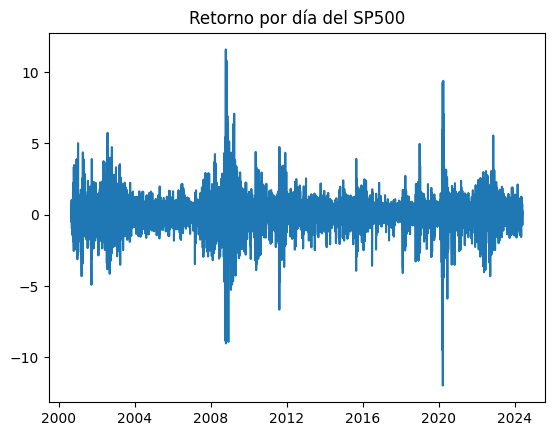

In [16]:
# grafica de los retornos de la serie
plt.plot(datos['Retorno'])
plt.title("Retorno por día del SP500")
plt.show()

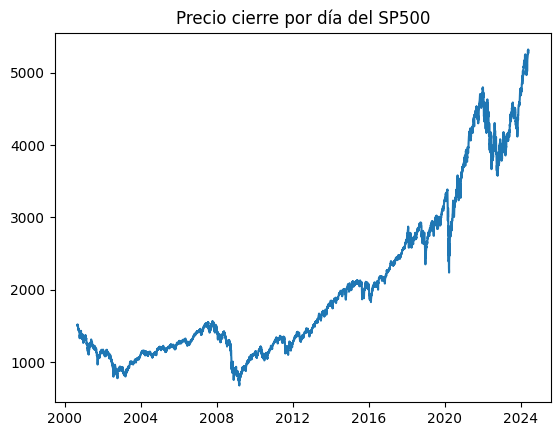

In [18]:
# grafica de los precios de la serie
plt.plot(datos['Close'])
plt.title("Precio cierre por día del SP500")
plt.show()

A través de la gráficas podemos evidenciar la diferencia de los datos, comprobando que los retornos presentan un comportamiento similar al ruido blanco (estacionario) mientras que los precios han registrado una tendencia al aumento en el periodo de tiempo observado (No estacionario).

## **2. Estacionariedad: Contraste de hipótesis - Prueba Dickey-Fuller**

### Prueba DF retorno

In [184]:
# Realizar la prueba de Dickey-Fuller aumentada
prueba = datos['Retorno'].iloc[1:]

result = sts.adfuller(prueba)

# Mostrar los resultados
print('Estadística de prueba:', result[0])
print('Valor p:', result[1])
print('Valores críticos:', result[4])
print('Resultados de la prueba:')
print('La serie es estacionaria' if result[1] < 0.05 else 'La serie no es estacionaria')

Estadística de prueba: -19.433039537660125
Valor p: 0.0
Valores críticos: {'1%': -3.431448592955108, '5%': -2.862025476427919, '10%': -2.5670284167429807}
Resultados de la prueba:
La serie es estacionaria


### Prueba DF Precios

In [185]:
# Realizar la prueba de Dickey-Fuller aumentada
prueba = datos['Close'].iloc[1:]

result = sts.adfuller(prueba)

# Mostrar los resultados
print('Estadística de prueba:', result[0])
print('Valor p:', result[1])
print('Valores críticos:', result[4])
print('Resultados de la prueba:')
print('La serie es estacionaria' if result[1] < 0.05 else 'La serie no es estacionaria')

Estadística de prueba: 2.0433518345354624
Valor p: 0.9987267016046045
Valores críticos: {'1%': -3.4314513683799994, '5%': -2.8620267026817205, '10%': -2.567029069511048}
Resultados de la prueba:
La serie no es estacionaria


## **3. Autocorrelación**

### Retornos

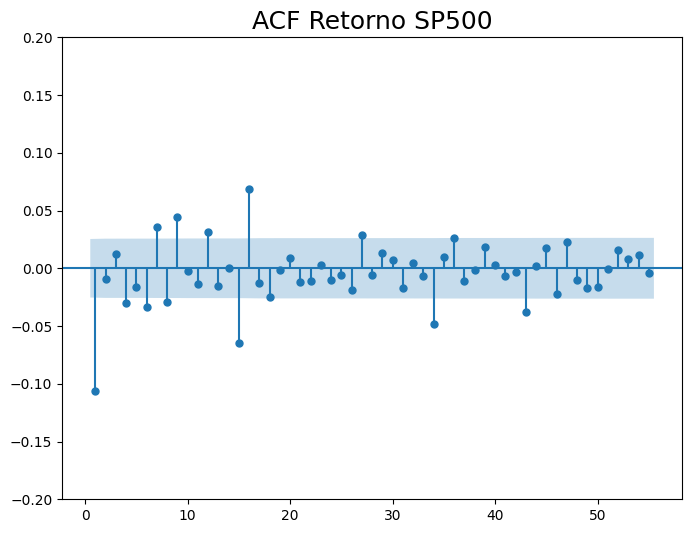

In [191]:
import statsmodels.api as sm

fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.tsa.plot_acf(datos['Retorno'].iloc[1:], lags=55, zero=False, ax=ax)
ax.set_ylim(-0.2, 0.2)
plt.title('ACF Retorno SP500', size=18)
plt.show()

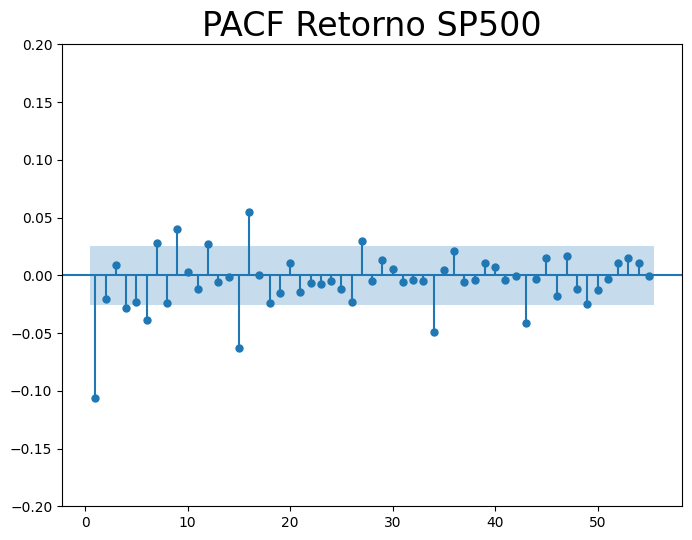

In [190]:
fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.tsa.plot_pacf(datos['Retorno'].iloc[1:], lags=55, zero=False, method='ols', ax=ax)
ax.set_ylim(-0.2, 0.2)
plt.title('PACF Retorno SP500', size=24)
plt.show()

### Precios

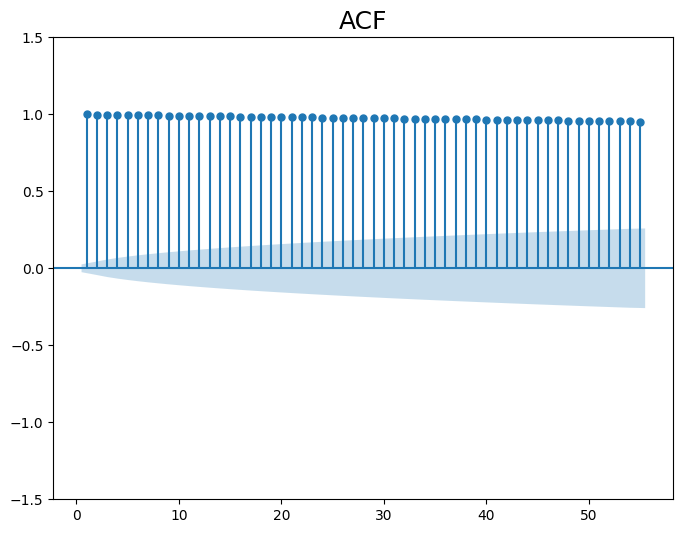

In [189]:
fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.tsa.plot_acf(datos['Close'].iloc[1:], lags=55, zero=False, ax=ax)
ax.set_ylim(-1.5, 1.5)
plt.title('ACF Precio SP500', size=18)
plt.show()

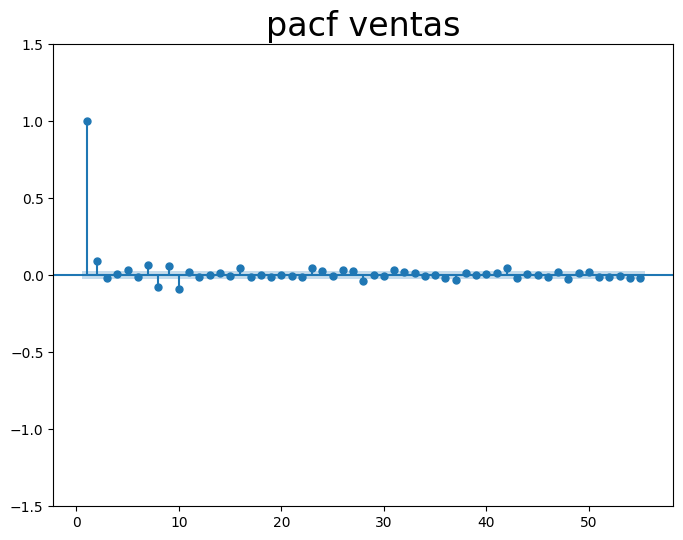

In [188]:
fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.tsa.plot_pacf(datos['Close'].iloc[1:], lags=55, zero=False, method='ols', ax=ax)
ax.set_ylim(-1.5, 1.5)
plt.title('PACF Precio SP500', size=24)
plt.show()

## **5. Modelos**

A continuación se presentan los modelos estacionarios: 1) **Autorregresivos**, 2) **Medias Móviles** y 3) **Autorregresivo de Medias Móviles** con la idea de analizar si es posible generar predicciones del retorno de la acción SP500.

## **Autorregresivos (AR)**

In [40]:
# contraste de razon de verosimilitudes / Likelihood Ratio Test
from scipy.stats import chi2

def LLR_test(mod_1, mod_2, DF=1):
  L1=mod_1.llf
  L2=mod_2.llf
  LR=(2*(L2-L1))
  p=chi2.sf(LR, DF).round(3)
  return p

Selección orden del modelo

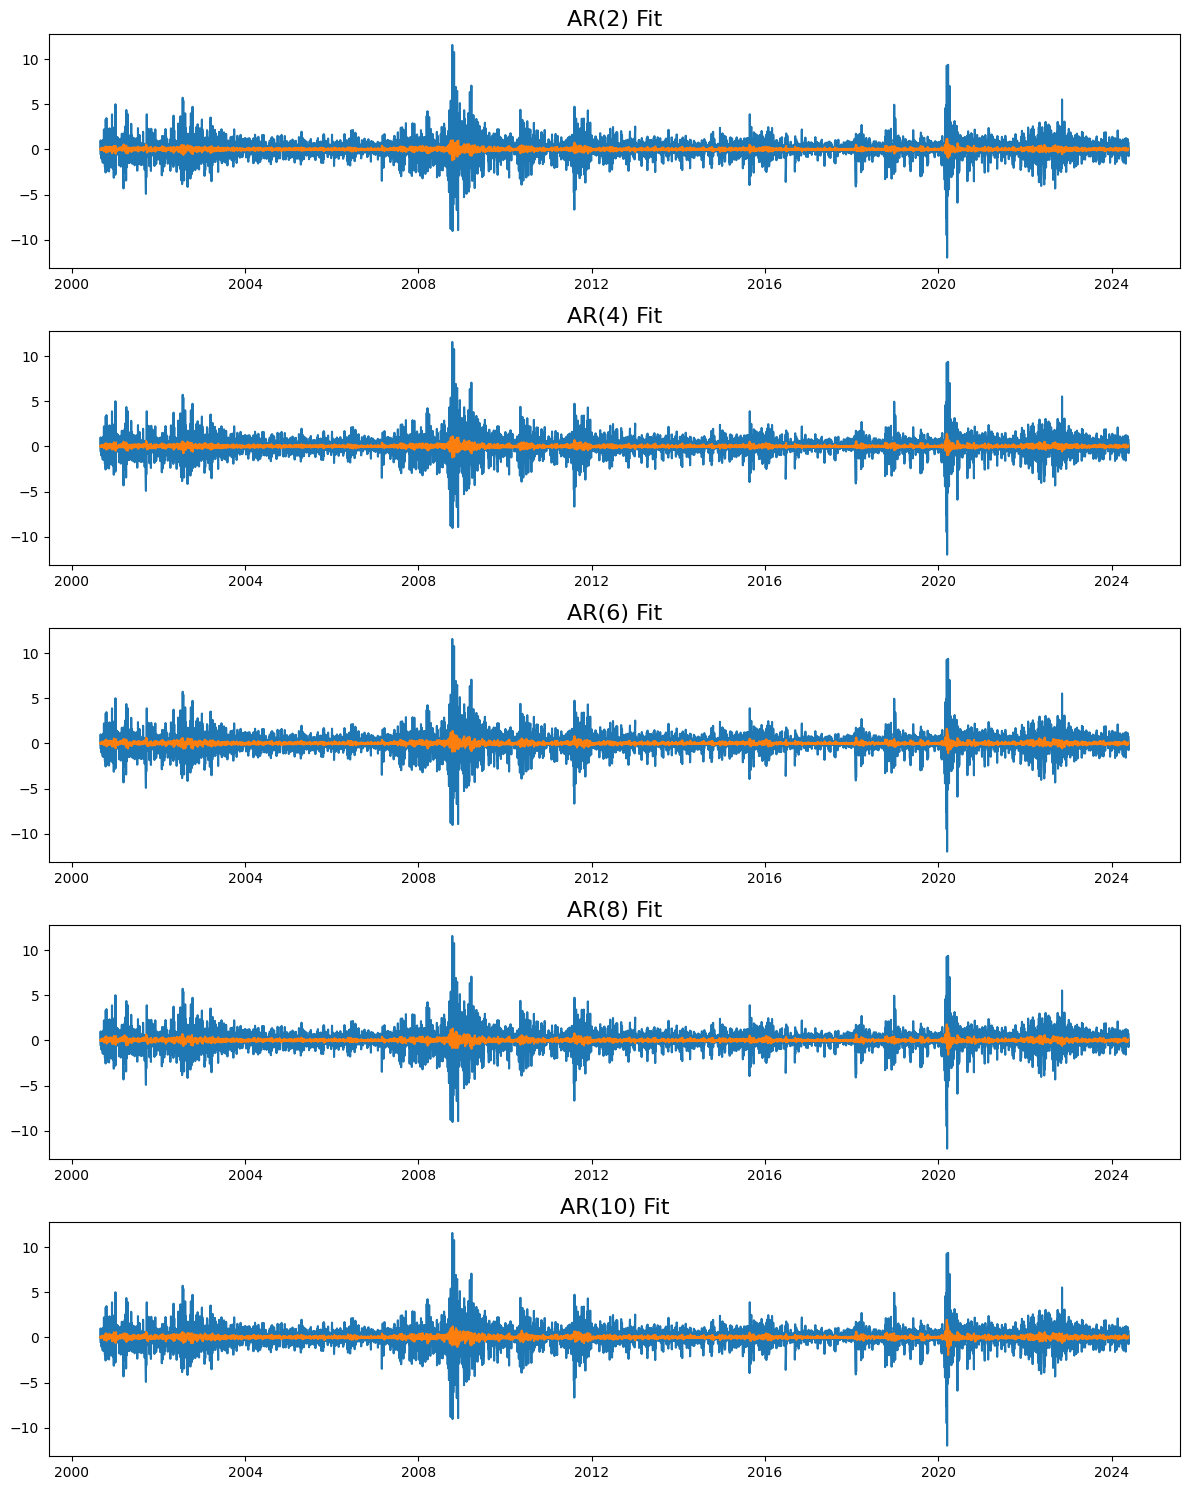

In [55]:
plt.figure(figsize=(12,15))

ar_orders = [2,4,6,8,10]
fitted_model_dict = {}

for idx, ar_order in enumerate(ar_orders):

  # create AR(P) models
  ar_model = ARIMA(datos['Retorno'], order=(ar_order, 0, 0))
  ar_model_fit = ar_model.fit()
  fitted_model_dict[ar_order] = ar_model_fit
  plt.subplot(5,1,idx+1)
  plt.plot(datos['Retorno'])
  plt.plot(ar_model_fit.fittedvalues)
  plt.title('AR(%s) Fit' %ar_order, fontsize=16)

  plt.tight_layout()

**Mejor AIC AR(10)**

In [56]:
# comparación criterio AIC
for ar_order in ar_orders:
  print('AIC for AR(%s): %s'% (ar_order,fitted_model_dict[ar_order].aic))

AIC for AR(2): 19292.361619081596
AIC for AR(4): 19291.01541710786
AIC for AR(6): 19282.8115554057
AIC for AR(8): 19278.52391316631
AIC for AR(10): 19272.970344985628


**Mejor BIC AR(2)**

In [58]:
# comparación criterio BIC
for ar_order in ar_orders:
  print('BIC for AR(%s): %s'% (ar_order,fitted_model_dict[ar_order].bic))

BIC for AR(2): 19319.14096771623
BIC for AR(4): 19331.184440059817
BIC for AR(6): 19336.370252674973
BIC for AR(8): 19345.4722847529
BIC for AR(10): 19353.308390889535


**Mejor LLF AR(10)**

In [59]:
# comparación criterio Loglikelihood
for ar_order in ar_orders:
  print('Log Likelihood for AR(%s): %s'% (ar_order,fitted_model_dict[ar_order].llf))

Log Likelihood for AR(2): -9642.180809540798
Log Likelihood for AR(4): -9639.50770855393
Log Likelihood for AR(6): -9633.40577770285
Log Likelihood for AR(8): -9629.261956583156
Log Likelihood for AR(10): -9624.485172492814


In [118]:
model_ar = ARIMA(datos['Retorno'], order=(10, 0,0))
resultados_ar = model_ar.fit()

In [119]:
resultados_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Retorno   No. Observations:                 5972
Model:                ARIMA(10, 0, 0)   Log Likelihood               -9624.485
Date:                Wed, 29 May 2024   AIC                          19272.970
Time:                        19:38:58   BIC                          19353.308
Sample:                             0   HQIC                         19300.876
                               - 5972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0285      0.015      1.882      0.060      -0.001       0.058
ar.L1         -0.1067      0.007    -15.274      0.000      -0.120      -0.093
ar.L2         -0.0221      0.006     -3.858      0.000      -0.033      -0.011
ar.L3          0.0076      0.007      1.112      0.266      -0.006       0.021
ar.L4         -0.0315      0.007     -4.787      0.000      -0.044      -0.019
ar.L5         -0.0249      0.006     -3.876      0.000      -0.037      -0.012
ar.L6         -0.0366      0.006     -5.646      0.000      -0.049      -0.024
ar.L7          0.0263      0.007      4.024      0.000       0.013       0.039
ar.L8         -0.0201      0.007     -2.860      0.004      -0.034      -0.006
ar.L9          0.0402      0.007      6.165      0.000       0.027       0.053
ar.L10         0.0026      0.007      0.369      0.712      -0.011       0.016
sigma2         1.4709      0.012    121.209      0.000       1.447       1.495
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             22076.32
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.36
Prob(H) (two-sided):                  0.26   Kurtosis:                        12.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **Medias Móviles (MA)**

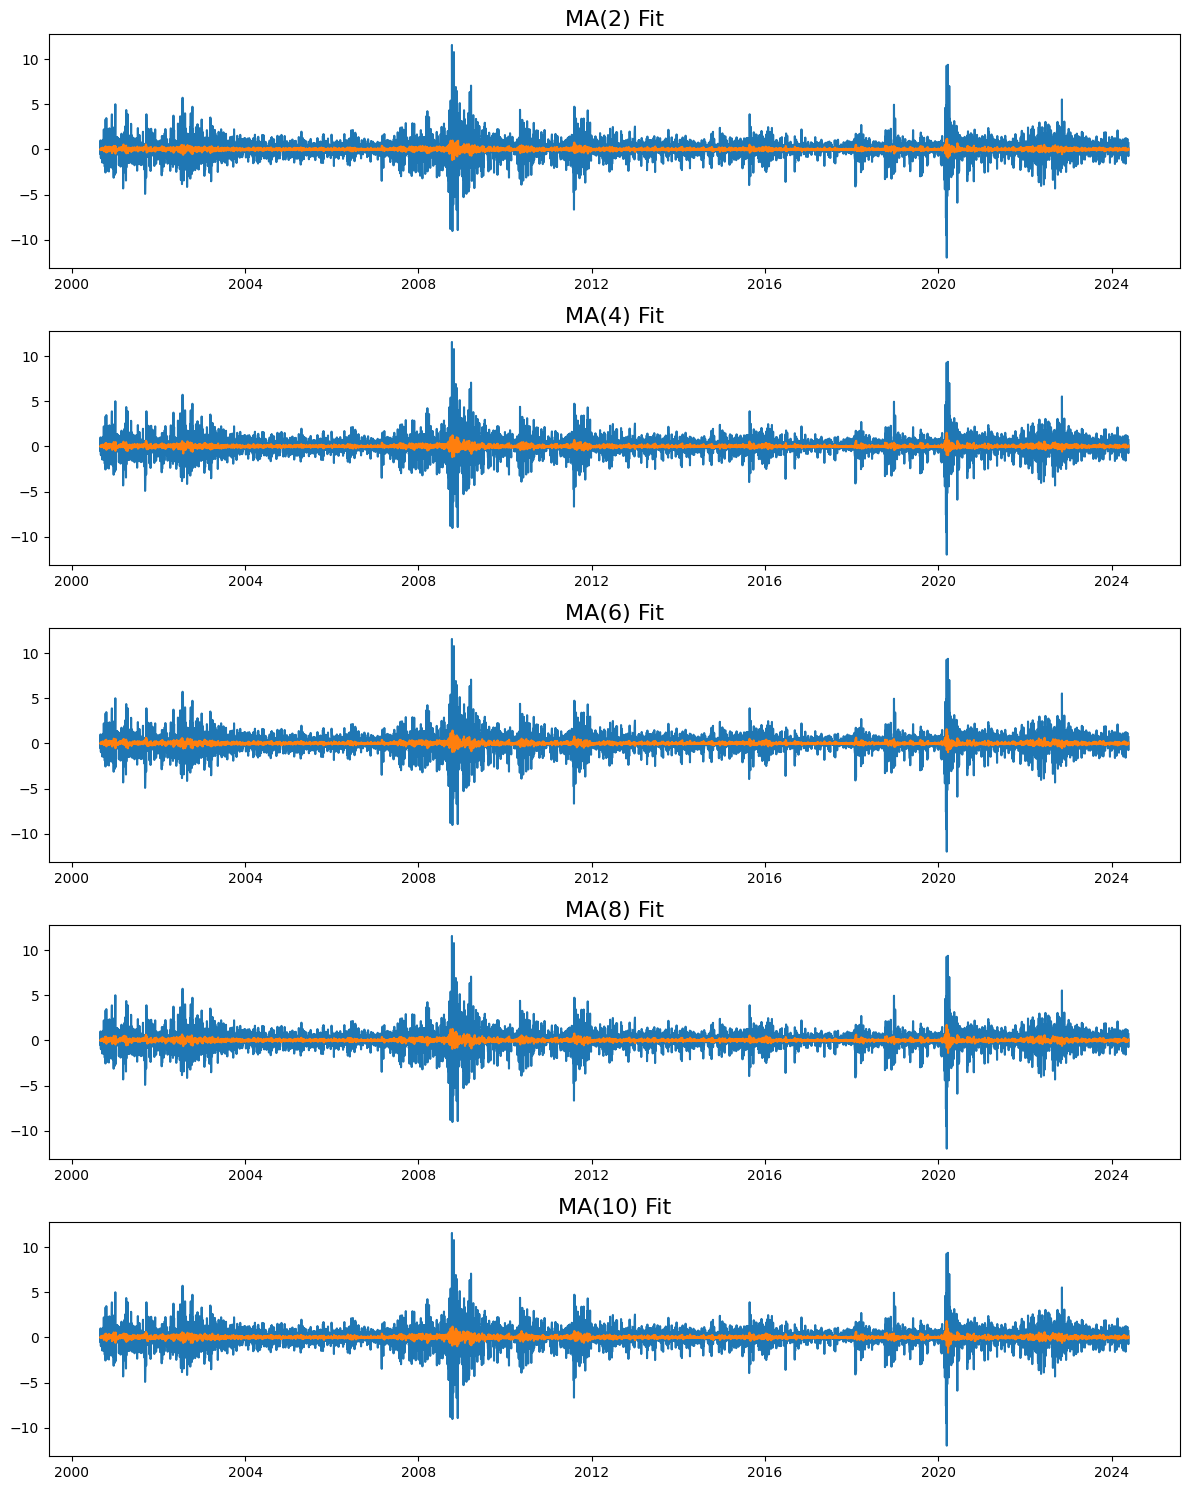

In [135]:
plt.figure(figsize=(12, 15))

ma_orders = [2, 4, 6, 8, 10]
fitted_model_dict_ma = {}

for idx, ma_order in enumerate(ma_orders):
    # Create MA(Q) models
    ma_model = ARIMA(datos['Retorno'], order=(0, 0, ma_order))
    ma_model_fit = ma_model.fit()
    fitted_model_dict_ma[ma_order] = ma_model_fit
    plt.subplot(5, 1, idx + 1)
    plt.plot(datos['Retorno'])
    plt.plot(ma_model_fit.fittedvalues)
    plt.title('MA(%s) Fit' % ma_order, fontsize=16)

plt.tight_layout()
plt.show()


**Mejor AIC AR(10)**

In [136]:
# comparación criterio AIC
for ma_order in ma_orders:
  print('AIC for AR(%s): %s'% (ma_order,fitted_model_dict_ma[ma_order].aic))

AIC for AR(2): 19292.562425820637
AIC for AR(4): 19288.346523077897
AIC for AR(6): 19285.520565339917
AIC for AR(8): 19281.82589782383
AIC for AR(10): 19278.03676144825


**Mejor BIC AR(2)**

In [137]:
# comparación criterio BIC
for ma_order in ma_orders:
  print('BIC for AR(%s): %s'% (ma_order,fitted_model_dict_ma[ma_order].bic))

BIC for AR(2): 19319.34177445527
BIC for AR(4): 19328.515546029852
BIC for AR(6): 19339.07926260919
BIC for AR(8): 19348.77426941042
BIC for AR(10): 19358.374807352156


**Mejor LLF AR(10)**

In [138]:
# comparación criterio Loglikelihood
for ma_order in ma_orders:
  print('Log Likelihood for AR(%s): %s'% (ma_order,fitted_model_dict_ma[ma_order].llf))

Log Likelihood for AR(2): -9642.281212910319
Log Likelihood for AR(4): -9638.173261538948
Log Likelihood for AR(6): -9634.760282669959
Log Likelihood for AR(8): -9630.912948911915
Log Likelihood for AR(10): -9627.018380724125


In [139]:
model_ma = ARIMA(datos['Retorno'], order=(0, 0, 10))
resultados_ma = model_ma.fit()

In [140]:
resultados_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Retorno   No. Observations:                 5972
Model:                ARIMA(0, 0, 10)   Log Likelihood               -9627.018
Date:                Wed, 29 May 2024   AIC                          19278.037
Time:                        21:31:02   BIC                          19358.375
Sample:                             0   HQIC                         19305.942
                               - 5972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0285      0.015      1.873      0.061      -0.001       0.058
ma.L1         -0.1073      0.007    -15.411      0.000      -0.121      -0.094
ma.L2         -0.0095      0.006     -1.718      0.086      -0.020       0.001
ma.L3          0.0081      0.007      1.177      0.239      -0.005       0.022
ma.L4         -0.0303      0.006     -4.671      0.000      -0.043      -0.018
ma.L5         -0.0206      0.007     -3.171      0.002      -0.033      -0.008
ma.L6         -0.0248      0.006     -4.087      0.000      -0.037      -0.013
ma.L7          0.0274      0.006      4.222      0.000       0.015       0.040
ma.L8         -0.0181      0.007     -2.715      0.007      -0.031      -0.005
ma.L9          0.0381      0.006      5.912      0.000       0.025       0.051
ma.L10        -0.0032      0.007     -0.467      0.641      -0.016       0.010
sigma2         1.4721      0.012    121.717      0.000       1.448       1.496
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             22459.23
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.35
Prob(H) (two-sided):                  0.20   Kurtosis:                        12.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## **Autorregresivo en Medias Móviles (ARMA)**

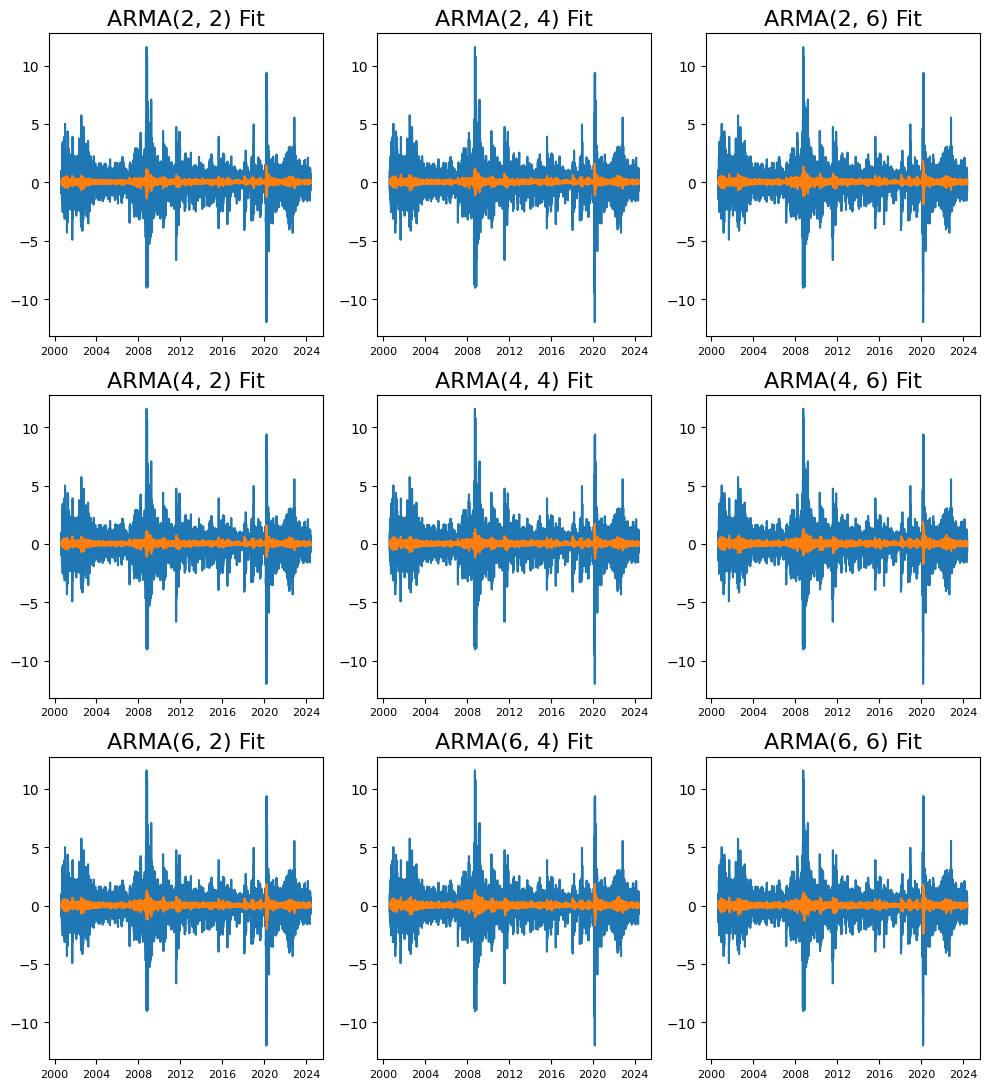

In [134]:
plt.figure(figsize=(10,11))

# Orders for AR and MA components
ar_orders = [2, 4, 6]
ma_orders = [2, 4, 6 ]

# Dictionary to store fitted models
fitted_model_dict = {}

# Loop through AR and MA orders
for idx_ar, ar_order in enumerate(ar_orders):
    for idx_ma, ma_order in enumerate(ma_orders):
        if ar_order == 0 and ma_order == 0:
            continue  # Skip ARIMA(0,0,0)

        # Create ARMA(P,Q) models
        arma_model = ARIMA(datos['Retorno'], order=(ar_order, 0, ma_order))
        arma_model_fit = arma_model.fit()
        fitted_model_dict[(ar_order, ma_order)] = arma_model_fit

        plt.subplot(len(ar_orders), len(ma_orders), idx_ar*len(ma_orders) + idx_ma + 1)
        plt.plot(datos['Retorno'])
        plt.plot(arma_model_fit.fittedvalues)
        plt.title('ARMA(%s, %s) Fit' %(ar_order, ma_order), fontsize=16)

        plt.xticks(fontsize=8)


plt.tight_layout()
plt.show()

Aspectos para considerar al momento de elegir el orden de un modelo:

1.   Coeficientes significativos = P-valor < 0.05
2.   Alta log-verosimilitud
3.   Bajo criterio de informacion (AIC y BIC)

*   LLR (Likelihood Ratio Test): El LLR es una prueba estadística utilizada para comparar la bondad de ajuste de dos modelos, uno más restringido y otro menos restringido. El LLR se utiliza para comparar un modelo ARIMA más simple con un modelo ARIMA más complejo que incluye más términos.

*   El LLF es la función que se maximiza durante el proceso de estimación de un modelo. Busca maximizar el LLF para encontrar los parámetros que mejor ajustan el modelo a los datos observados.

En general, en términos de criterios de información como el BIC (Bayesian Information Criterion) y el AIC (Akaike Information Criterion), se prefiere un valor menor, ya que indica un mejor equilibrio entre el ajuste del modelo y su complejidad.

Para el logaritmo de la verosimilitud, un valor más alto indica un mejor ajuste del modelo a los datos observados. Por lo tanto, en este caso, se preferiría un valor más alto de log-verosimilitud.

---

**NOTA: para generar la prueba de LLR es necesario que los modelos esten anidados, es decir, que del modelo complejo del ARMA se encuentre el AR o MA**

Ej: ARMA(p1,q1) y ARMA(p2,q2)

Requisitos:
*   p1 + q1 > p2 + q2
*   p1 >= p2
*   q1 >= q2


---


* **Modelo Autorregresivo (AR), Modelo de Medias Móviles (MA) y ARMA:** Al observar las gráficas correspondientes a varios órdenes de modelos autorregresivos y de medias móviles, se determina que este tipo de modelo no es adecuado para predecir el retorno de la acción SP500. Además, al considerar el mejor modelo según las métricas BIC, AIC y LLF, se encuentra que el modelo de orden (10) tiene varios términos autorregresivos y de medias moviles sin significancia para la predicción, es decir, tienen un valor p mayor a 0.05.


*  **Comportamiento de los Datos:** De acuerdo con la serie de tiempo proporcionada y los modelos AR y MA, se puede concluir que los datos tienen un comportamiento correspondiente al ruido blanco. Esto significa que no presentan tendencias y que sus valores son independientes entre sí, razón por la cual el pronóstico de los retornos no es viable.

## Incluir diferenciación: Modelo ARIMA

AR**I**MA - **Integrado**: explica el número de diferencias no estacionales que debemos examinar para esstablecer la estacionariedad (Estima los saltos entre los precios, modela las diferencias de un periodo al siguiente, en lugar de los datos como tal).

*   ARIMA(p,d,q) - Integración de la serie. Posee 3 ordenes: **P** componentes AR, **D** orden de integración y **Q** componentes MA.
*   Se integra d veces la serie de tiempo original.

Evaluar si al incluir integración y cambiar la frecuencia a trimestre el modelo logra adaptarse mejor a los datos, esto luego de haber generado modelos AR, MA y ARMA y no obtener resultados satisfactorios.

In [23]:
datos_trim = yf.download(tickers="^GSPC", start="2000-08-29", end="2024-05-28", interval="3mo", auto_adjust=True)

[*********************100%%**********************]  1 of 1 completed


In [24]:
datos_trim['Retorno'] = datos_trim['Close'].pct_change(1) * 100
datos_trim.head()

,Open,High,Low,Close,Volume,Retorno
Date,,,,,,
2000-08-01,1517.680054,1530.089966,1305.790039,1429.400024,46789700000,NaN
2000-11-01,1429.400024,1438.459961,1254.069946,1366.010010,71972900000,-4.434729
2001-02-01,1366.010010,1376.380005,1081.189941,1249.459961,74861000000,-8.532152
2001-05-01,1249.459961,1315.930054,1165.540039,1211.229980,73067640000,-3.059720
2001-08-01,1211.229980,1226.270020,944.750000,1059.780029,78335770000,-12.503815


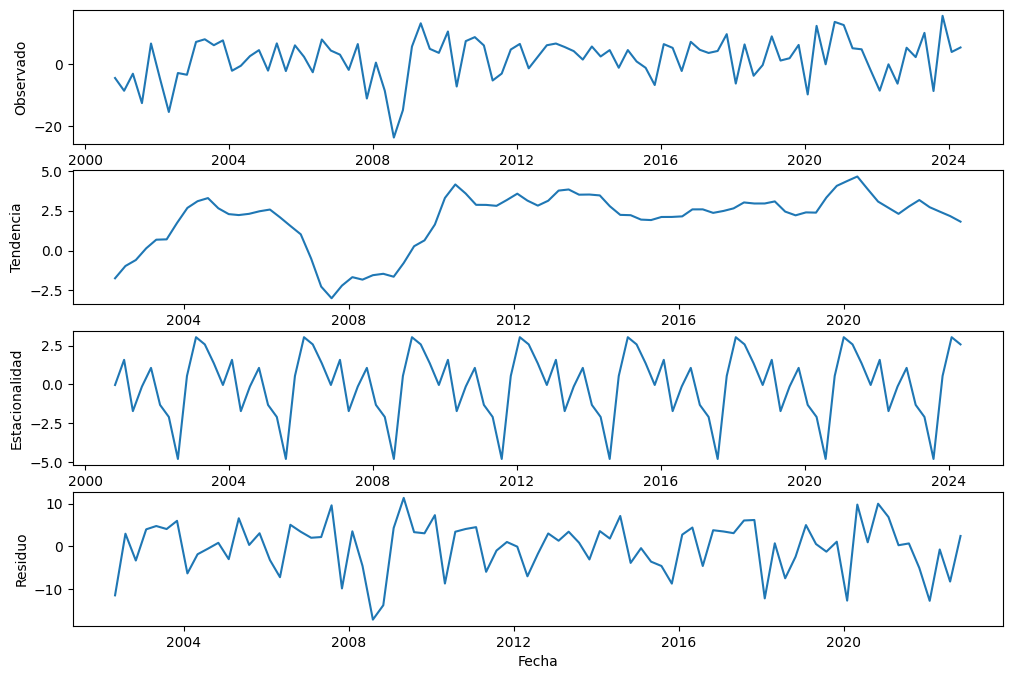

In [25]:

# Realizar el análisis de estacionalidad
result1 = seasonal_decompose(datos_trim['Retorno'].iloc[1:], model='additive', period=12)

# Graficar los componentes
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result1.observed)
plt.ylabel('Observado')
plt.subplot(412)
plt.plot(result1.trend)
plt.ylabel('Tendencia')
plt.subplot(413)
plt.plot(result1.seasonal)
plt.ylabel('Estacionalidad')
plt.subplot(414)
plt.plot(result1.resid)
plt.ylabel('Residuo')
plt.xlabel('Fecha')
plt.show()

In [296]:
model_arima = ARIMA(datos_trim['Retorno'], order=(5, 2, 0))
results_arima = model_arima.fit()
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Retorno   No. Observations:                   96
Model:                 ARIMA(5, 2, 0)   Log Likelihood                -339.726
Date:                Wed, 29 May 2024   AIC                            691.452
Time:                        23:44:40   BIC                            706.711
Sample:                    08-01-2000   HQIC                           697.616
                         - 05-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3581      0.099    -13.663      0.000      -1.553      -1.163
ar.L2         -1.2059      0.151     -7.963      0.000      -1.503      -0.909
ar.L3         -0.9047      0.160     -5.668      0.000      -1.218      -0.592
ar.L4         -0.5935      0.167     -3.546      0.000      -0.922      -0.265
ar.L5         -0.2858      0.126     -2.274      0.023      -0.532      -0.040
sigma2        73.1871     10.624      6.889      0.000      52.364      94.010
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 3.66
Prob(Q):                              0.51   Prob(JB):                         0.16
Heteroskedasticity (H):               1.14   Skew:                             0.16
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

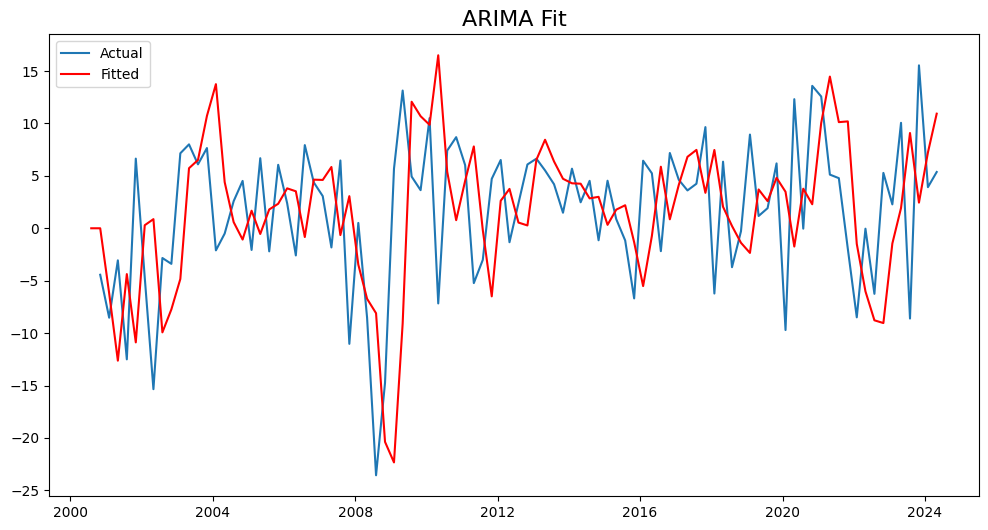

In [297]:
plt.figure(figsize=(12, 6))
plt.plot(datos_trim['Retorno'], label='Actual')
plt.plot(results_arima.fittedvalues, color='red', label='Fitted')
plt.title('ARIMA Fit', fontsize=16)
plt.legend()
plt.show()

**Diferencias clave de los valores ajustados vs los valores de predicción del modelo:**

*  Horizonte temporal: Los valores ajustados se refieren al pasado (datos de entrenamiento), mientras que los valores predichos se enfocan en el futuro (más allá de los datos de entrenamiento).
*   Certeza: Los valores ajustados son estimaciones puntuales que representan el mejor ajuste del modelo a los datos históricos, mientras que los valores predichos conllevan un grado de incertidumbre y se presentan como intervalos de predicción que abarcan un rango probable de valores futuros.
*   Objetivo: Los valores ajustados sirven principalmente para evaluar el modelo y comprender la dinámica histórica, mientras que los valores predichos se utilizan para anticipar el comportamiento futuro de la serie temporal.

En resumen, los valores ajustados y los valores predichos son componentes complementarios del modelado ARIMA. Los valores ajustados ayudan a garantizar un buen ajuste del modelo a los datos históricos, mientras que los valores predichos permiten realizar pronósticos informados sobre el futuro.

**Analogía:**

Plano de arquitecto vs. Sitio de construcción:

*  Valores ajustados: Considerar el plano de un arquitecto que detalla meticulosamente las dimensiones, el diseño y los elementos estructurales de un edificio. El plano representa la capacidad del modelo para explicar y dar cuenta de los puntos de datos observados, proporcionando una comprensión detallada de la estructura histórica de la serie temporal.

*  Valores predichos: Imaginar el sitio de construcción donde el edificio está tomando forma. Los trabajadores utilizan el plano como guía, pero también realizan ajustes en función de las condiciones en tiempo real y circunstancias imprevistas. Los valores pronosticados representan la capacidad del modelo para traducir su comprensión del pasado en predicciones sobre el futuro, tomando en cuenta posibles cambios o eventos inesperados.